In [1]:
#Importing all the packages and the CSV file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandasql import sqldf
customer_pricing_table = pd.read_csv('Customer table.csv')

In [2]:
#Removing the timestamp values from the switch columns
customer_pricing_table['switch_start'] = customer_pricing_table['switch_start'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
customer_pricing_table['switch_end'] = customer_pricing_table['switch_end'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))

#Replacing comma to dot 
customer_pricing_table = customer_pricing_table.replace(',', '.', regex=True)


#CSV Preview
print(customer_pricing_table)

      id  customer_id  switches   value switch_start  switch_end
0      1         1111         5    99.9   2022-01-10  2022-12-31
1      2         1111         5  101.99   2023-01-01  2023-01-31
2      3         1111         5  103.98   2023-02-01  2023-02-28
3      4         1111         5  105.97   2023-03-01  2023-03-31
4      5         1111         5  107.96   2023-04-01  2023-05-01
..   ...          ...       ...     ...          ...         ...
145  146         1239         1    99.9   2023-01-01  2024-01-01
146  147         1240         1    99.9   2023-02-01  2024-02-01
147  148         1241         1    99.9   2023-03-01  2024-02-29
148  149         1242         1    99.9   2023-01-01  2024-01-01
149  150         1243         1    99.9   2023-02-01  2024-02-01

[150 rows x 6 columns]


In [3]:
#Importing datetime to generate a dataframe with all dates from the beginning until today
from datetime import datetime

# start and end date
now = datetime.now()
start_date = datetime.strptime("2022-01-10", "%Y-%m-%d")
end_date = now.strftime("%Y-%m-%d")

#Preview
date_list = pd.date_range(start_date, end_date, freq='D')
print(f"Creating list of dates starting from {start_date} to {end_date}")
print(date_list)

Creating list of dates starting from 2022-01-10 00:00:00 to 2023-05-08
DatetimeIndex(['2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13',
               '2022-01-14', '2022-01-15', '2022-01-16', '2022-01-17',
               '2022-01-18', '2022-01-19',
               ...
               '2023-04-29', '2023-04-30', '2023-05-01', '2023-05-02',
               '2023-05-03', '2023-05-04', '2023-05-05', '2023-05-06',
               '2023-05-07', '2023-05-08'],
              dtype='datetime64[ns]', length=484, freq='D')


In [4]:
from pandas.tseries.offsets import MonthEnd

#Creating the date dataframe
dates_df = pd.DataFrame({'Date': date_list})
dates_df['EOM'] = pd.to_datetime(dates_df['Date'], format='%Y-%m-%d') + MonthEnd(0)

#Transforming all the dates in yyyy-mm-dd
dates_df['Date'] = dates_df['Date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
dates_df['EOM'] = dates_df['EOM'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))


#Overview of dates
print(dates_df)

           Date         EOM
0    2022-01-10  2022-01-31
1    2022-01-11  2022-01-31
2    2022-01-12  2022-01-31
3    2022-01-13  2022-01-31
4    2022-01-14  2022-01-31
..          ...         ...
479  2023-05-04  2023-05-31
480  2023-05-05  2023-05-31
481  2023-05-06  2023-05-31
482  2023-05-07  2023-05-31
483  2023-05-08  2023-05-31

[484 rows x 2 columns]


In [5]:
#Transforming all the dates in yyyy-mm-dd from the CSV file
customer_pricing_table['switch_start'] = customer_pricing_table['switch_start'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
customer_pricing_table['switch_end'] = customer_pricing_table['switch_end'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))

In [6]:
#Testing SQL environment 
pysqldf = lambda q: sqldf(q)
pysqldf("SELECT * FROM customer_pricing_table cpt")

,id,customer_id,switches,value,switch_start,switch_end
0,1,1111,5,99.9,2022-01-10,2022-12-31
1,2,1111,5,101.99,2023-01-01,2023-01-31
2,3,1111,5,103.98,2023-02-01,2023-02-28
3,4,1111,5,105.97,2023-03-01,2023-03-31
4,5,1111,5,107.96,2023-04-01,2023-05-01
...,...,...,...,...,...,...
145,146,1239,1,99.9,2023-01-01,2024-01-01
146,147,1240,1,99.9,2023-02-01,2024-02-01
147,148,1241,1,99.9,2023-03-01,2024-02-29
148,149,1242,1,99.9,2023-01-01,2024-01-01


In [7]:
# Selecting one customer to test the join on day level
customer_1111 = pysqldf("""
           select 
           DISTINCT
           dd.Date,
           dd.EOM, 
            cpt.*
           from dates_df dd
               left join customer_pricing_table cpt
                   on dd.Date >= cpt.switch_start 
                       and dd.Date <= cpt.switch_end
           where customer_id = 1111
           order by 1 asc
        """)

print(customer_1111)

           Date         EOM  id  customer_id  switches   value switch_start  \
0    2022-01-10  2022-01-31   1         1111         5    99.9   2022-01-10   
1    2022-01-11  2022-01-31   1         1111         5    99.9   2022-01-10   
2    2022-01-12  2022-01-31   1         1111         5    99.9   2022-01-10   
3    2022-01-13  2022-01-31   1         1111         5    99.9   2022-01-10   
4    2022-01-14  2022-01-31   1         1111         5    99.9   2022-01-10   
..          ...         ...  ..          ...       ...     ...          ...   
472  2023-04-27  2023-04-30   5         1111         5  107.96   2023-04-01   
473  2023-04-28  2023-04-30   5         1111         5  107.96   2023-04-01   
474  2023-04-29  2023-04-30   5         1111         5  107.96   2023-04-01   
475  2023-04-30  2023-04-30   5         1111         5  107.96   2023-04-01   
476  2023-05-01  2023-05-31   5         1111         5  107.96   2023-04-01   

     switch_end  
0    2022-12-31  
1    2022-12-31

In [8]:
#Checking all customer ids and the number of switches, rows and min/max dates based on day level
customer_check = pysqldf("""
            select 
                distinct customer_id, 
                switches,
                count(distinct value) as distinct_switch_value,
                count (*) as row_count,
                min(Date) as min_date, 
                max(Date) as max_date
            from dates_df dd
                left join customer_pricing_table cpt
                    on dd.Date >= cpt.switch_start 
                    and dd.Date <= cpt.switch_end
            group by 1,2 
        """)

print(customer_check)

     customer_id  switches  distinct_switch_value  row_count    min_date  \
0           1111         5                      5        477  2022-01-10   
1           1112         2                      2        128  2023-01-01   
2           1113         3                      3        128  2023-01-01   
3           1114         1                      1        159  2022-12-01   
4           1115         1                      1        159  2022-12-01   
..           ...       ...                    ...        ...         ...   
128         1239         1                      1        128  2023-01-01   
129         1240         1                      1         97  2023-02-01   
130         1241         1                      1         69  2023-03-01   
131         1242         1                      1        128  2023-01-01   
132         1243         1                      1         97  2023-02-01   

       max_date  
0    2023-05-01  
1    2023-05-08  
2    2023-05-08  
3    2023-05-08

In [9]:
#Final output on date level
customer_final = pysqldf("""
           select 
           DISTINCT
            dd.EOM,
            row_number()over (partition by customer_id order by dd.date) as idx,
            cpt.*
           from dates_df dd
               left join customer_pricing_table cpt
                   on dd.Date >= cpt.switch_start 
                       and dd.Date <= cpt.switch_end
           order by 1 asc
        """)

print(customer_final)

              EOM  idx   id  customer_id  switches value switch_start  \
0      2022-01-31    1    1         1111         5  99.9   2022-01-10   
1      2022-01-31    2    1         1111         5  99.9   2022-01-10   
2      2022-01-31    3    1         1111         5  99.9   2022-01-10   
3      2022-01-31    4    1         1111         5  99.9   2022-01-10   
4      2022-01-31    5    1         1111         5  99.9   2022-01-10   
...           ...  ...  ...          ...       ...   ...          ...   
17937  2023-05-31   93  150         1243         1  99.9   2023-02-01   
17938  2023-05-31   94  150         1243         1  99.9   2023-02-01   
17939  2023-05-31   95  150         1243         1  99.9   2023-02-01   
17940  2023-05-31   96  150         1243         1  99.9   2023-02-01   
17941  2023-05-31   97  150         1243         1  99.9   2023-02-01   

       switch_end  
0      2022-12-31  
1      2022-12-31  
2      2022-12-31  
3      2022-12-31  
4      2022-12-31  
...

In [10]:
#Exporting CSV
customer_final.to_csv('customer_final.csv', index=False)

In [11]:
#Final output on EOM level
customer_final_EOM = pysqldf("""
           select 
           DISTINCT
            dd.EOM,
            cpt.*
           from dates_df dd
               left join customer_pricing_table cpt
                   on dd.EOM >= cpt.switch_start 
                       and dd.EOM <= cpt.switch_end
           order by 1 asc
        """)

print(customer_final_EOM)

#Exporting CSV
customer_final_EOM.to_csv('customer_final_eom.csv', index=False)

            EOM   id  customer_id  switches value switch_start  switch_end
0    2022-01-31    1         1111         5  99.9   2022-01-10  2022-12-31
1    2022-01-31   18         1120         5  99.9   2022-01-10  2022-12-31
2    2022-01-31   69         1166         4   101   2022-01-10  2022-12-31
3    2022-02-28    1         1111         5  99.9   2022-01-10  2022-12-31
4    2022-02-28   18         1120         5  99.9   2022-01-10  2022-12-31
..          ...  ...          ...       ...   ...          ...         ...
687  2023-05-31  146         1239         1  99.9   2023-01-01  2024-01-01
688  2023-05-31  147         1240         1  99.9   2023-02-01  2024-02-01
689  2023-05-31  148         1241         1  99.9   2023-03-01  2024-02-29
690  2023-05-31  149         1242         1  99.9   2023-01-01  2024-01-01
691  2023-05-31  150         1243         1  99.9   2023-02-01  2024-02-01

[692 rows x 7 columns]


In [12]:
#Total Value on EOM 
agg_EOM = pysqldf("""
           select 
            EOM,
            sum(cpt.value) as value
           from customer_final_EOM cpt
          group by 1 order by 1 asc
        """)

print(agg_EOM)

           EOM     value
0   2022-01-31    300.80
1   2022-02-28    300.80
2   2022-03-31    300.80
3   2022-04-30    300.80
4   2022-05-31    300.80
5   2022-06-30    300.80
6   2022-07-31    300.80
7   2022-08-31    300.80
8   2022-09-30    300.80
9   2022-10-31    800.30
10  2022-11-30   1399.70
11  2022-12-31   6894.20
12  2023-01-31   8927.49
13  2023-02-28  10487.37
14  2023-03-31  12343.46
15  2023-04-30  12743.95
16  2023-05-31  13135.49


In [13]:
#Output for acquired monthly cohort 
acquired_cohort = pysqldf("""
with customer_pricing_table_idx as (
select 
           DISTINCT 
            strftime ('%Y/%m',dd.EOM) AS EOM,
            row_number()over (partition by customer_id order by dd.date) as idx,
            cpt.customer_id,
            cpt.value
           from dates_df dd
               left join customer_pricing_table cpt
                   on dd.date = cpt.switch_start 
          )
          ,first_idx as (
          select * from customer_pricing_table_idx
          where idx = 1
          )
          ,customer_lifetime_value as (
          select 
              distinct customer_id, 
              sum(value) as lifetime_value
          from customer_final_EOM
          group by 1
          )
          select 
          distinct
              fi.EOM as acquisition_cohort, 
               sum(fi.value) as acquired_value,
               count(distinct fi.customer_id) as acquired_customers,
               sum(lifetime_value) as lifetime_value
          from first_idx fi
              left join customer_lifetime_value clv
                  on fi.customer_id = clv.customer_id
           group by 1 order by 1 asc
        """)

print(acquired_cohort)

  acquisition_cohort  acquired_value  acquired_customers  lifetime_value
0            2022/01           300.8                   3         4919.50
1            2022/10           499.5                   5         3996.00
2            2022/11           599.4                   6         4195.80
3            2022/12          5494.5                  55        32967.00
4            2023/01          2005.1                  20        10174.06
5            2023/02          1498.5                  15         5994.00
6            2023/03          1898.1                  19         5694.30
7            2023/04           499.5                   5          999.00
8            2023/05           499.5                   5          499.50


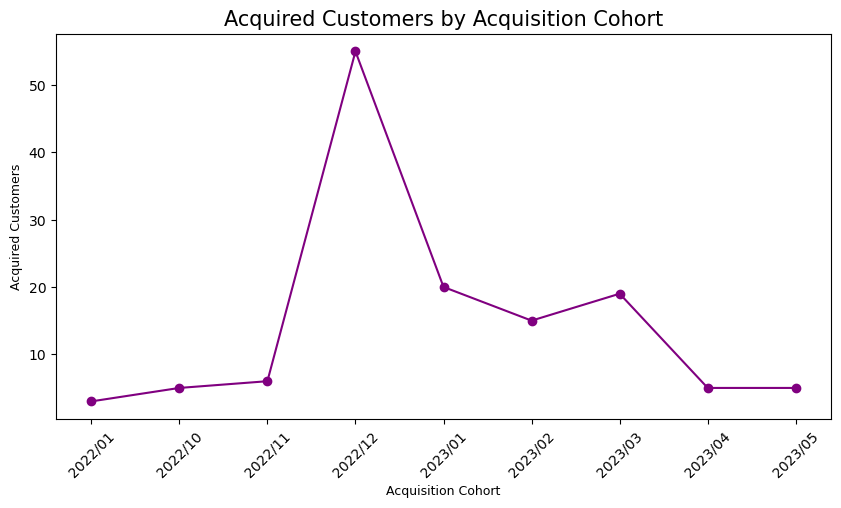

In [14]:
# create a line chart of acquired_customers by acquired_cohort
plt.figure(figsize=(10, 5))
plt.plot(acquired_cohort['acquisition_cohort'], acquired_cohort['acquired_customers'], marker='o', color='purple')

plt.title('Acquired Customers by Acquisition Cohort', fontsize=15)
plt.xlabel('Acquisition Cohort', fontsize=9)
plt.ylabel('Acquired Customers', fontsize=9)
plt.xticks(rotation=45)

plt.show()


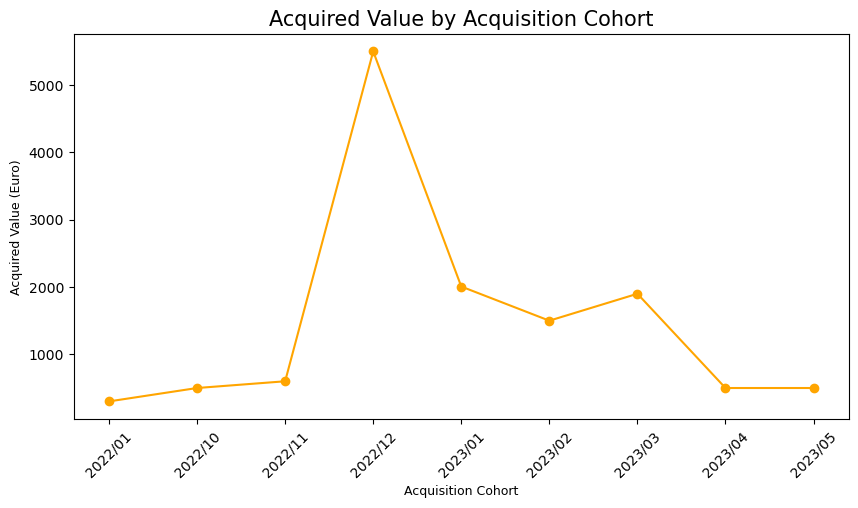

In [15]:
# create a line chart of acquired_value by acquired_cohort
plt.figure(figsize=(10, 5))
plt.plot(acquired_cohort['acquisition_cohort'], acquired_cohort['acquired_value'], marker='o', color='orange')

plt.title('Acquired Value by Acquisition Cohort', fontsize=15)
plt.xlabel('Acquisition Cohort', fontsize=9)
plt.ylabel('Acquired Value (Euro)', fontsize=9)
plt.xticks(rotation=45)

plt.show()


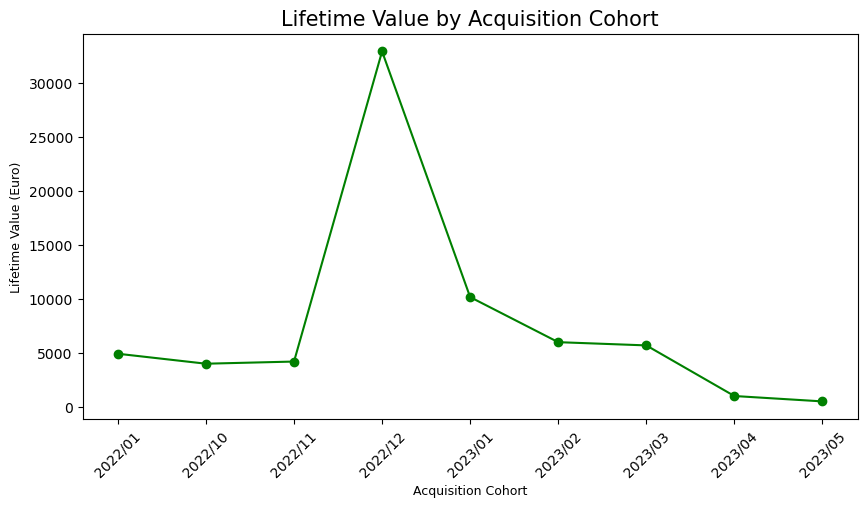

In [16]:
# create a line chart of total_eom_value by acquired_cohort
plt.figure(figsize=(10, 5))
plt.plot(acquired_cohort['acquisition_cohort'], acquired_cohort['lifetime_value'], marker='o', color='green')

plt.title('Lifetime Value by Acquisition Cohort', fontsize=15)
plt.xlabel('Acquisition Cohort', fontsize=9)
plt.ylabel('Lifetime Value (Euro)', fontsize=9)
plt.xticks(rotation=45)

plt.show()


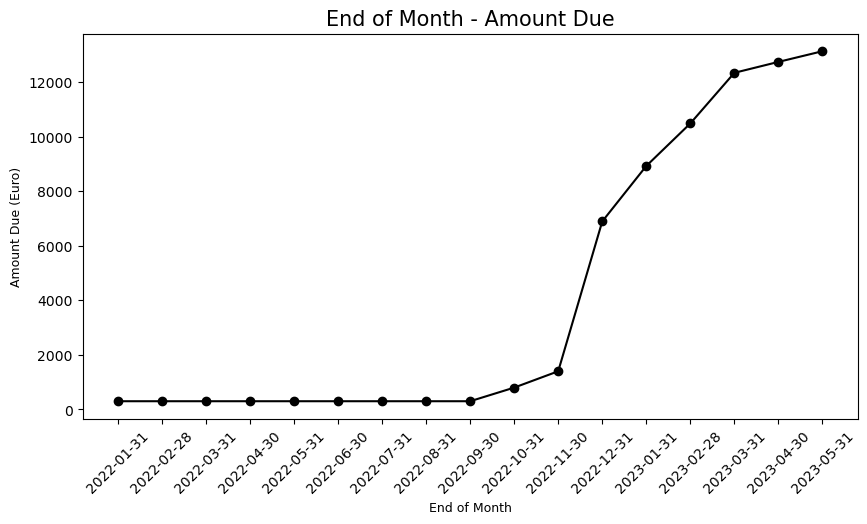

In [17]:
# create a line chart of Total Amount Due by End of Month
plt.figure(figsize=(10, 5))
plt.plot(agg_EOM['EOM'], agg_EOM['value'], marker='o', color='black')

plt.title('End of Month - Amount Due', fontsize=15)
plt.xlabel('End of Month', fontsize=9)
plt.ylabel('Amount Due (Euro)', fontsize=9)
plt.xticks(rotation=45)

plt.show()
